Using simple mathematical knowledge and existing algorithms written with Python, Numpy, Scipy, we will introduce the basics of PIV.

## What is Particle Image Velocimetry (PIV) about?

"Particle" Image Velocimetry (PIV) is a non-intrusive state-of-the-art technique[<sup>1,</sup>](#fn1)[<sup>2</sup>](#fn2) to get the velocity field of the flow being studied from images of small particles, called tracers.

It is based on image recording of the illuminated flow field using seeding particles (called tracers) which, when sufficiently small compared to the smallest characteristic length scales of the flow, are assumed to faithfully follow the flow dynamics (the degree to which the particles faithfully follow the flow is represented by the Stokes number). In practice, common sizes of the tracer particles are in the order of 5-100 microns. 
The entrained particles are generally made visible in a cross-section of the flow being studied by forming a coherent light sheet. In practice, the flow is illuminated twice using a laser light sheet, forming a plane where a camera is focused. The time delay between the pulses depends on the mean velocity and the image magnification. It is assumed that the tracer particles follow the local flow velocity between the two consecutive illuminations. The light scattered from the tracer particles is then imaged via an optical lens on a digital camera. The displacement of the particle images between two consecutive light pulses (respectively, frames) is determined through evaluation of the spatial cross-correlation function and image processing tools as implemented in OpenPIV.

The effectiveness of the measurement results strongly depends on a large number of parameters such as particles concentration, size distribution and shape, illumination source, recording device, and synchronization between the illumination, acquisition and recording systems (Huang et al., 1997). An appropriate choice of the different parameters of the cross correlation analysis (e.g., interrogation area, time between pulses, scaling) will influence the results accuracy. 

Read more about PIV in the following chapters:

---
<sup id="fn1">1</sup> Raffel et al., 2007\
<sup id="fn2">2</sup> Adrian, 1991


## How to estimate a velocity-field from a couple of grayscale particle images?

This tutorial will follow the simplest analysis path from the two images to the velocity field and some post-analysis.

In [22]:
# import the standard numerical and plotting packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import what is necessary from OpenPIV
from openpiv import tools, pyprocess, validation, filters, scaling

We have downloaded some sample images from a standard PIV images project, see http://www.pivchallenge.org/pub/#b

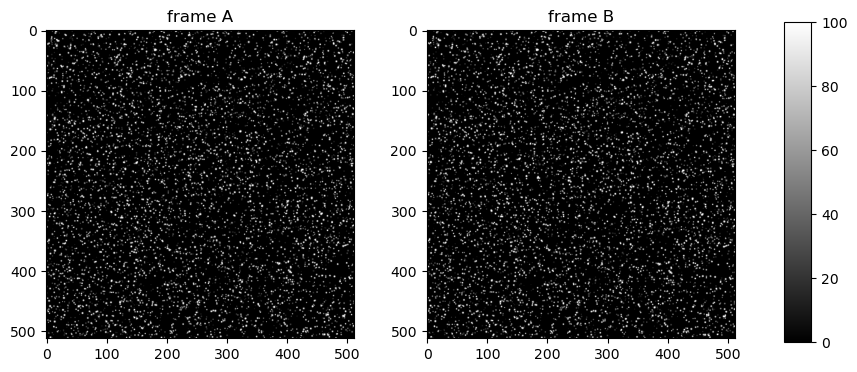

In [23]:
# load the images
a = tools.imread("./images/B005_1.tif")
b = tools.imread("./images/B005_2.tif")

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

img = axs[0].imshow(a, vmin=0, vmax=100, cmap=plt.cm.gray)
axs[0].set_title('frame A')

img = axs[1].imshow(b, vmin=0, vmax=100, cmap=plt.cm.gray)
axs[1].set_title('frame B')

cbar = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(img, cax=cbar)
plt.show()

The two images show the particles at two different times. But these images are way to big and contain too many particles to manually track the movement of individual particles from one frame to the other. Instead, we can analyze small regions of interest, called interrogation windows (IW). Typically, we can start with a size of 32 x 32 pixels or smaller. Until recently, the fast algorithms used powers of 2, so the historical sizes are always powers of 2: 8, 16, 32, 64, 128, ...

Let's take the first top left windows from each image.

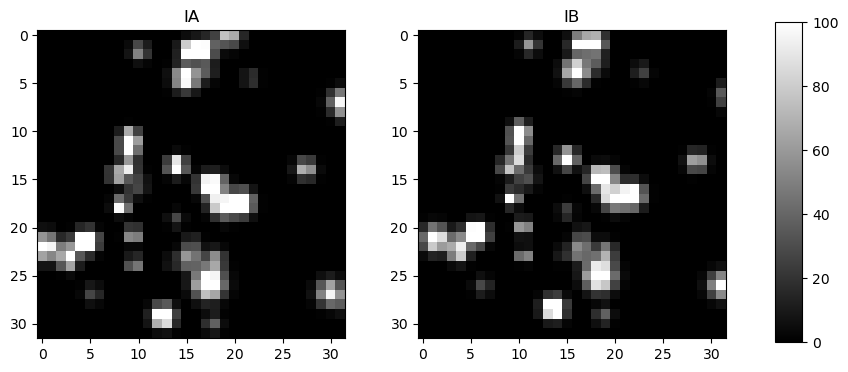

In [24]:
win_size = 32

a_win = a[:win_size, :win_size].copy()
b_win = b[:win_size, :win_size].copy()

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
img = axs[0].imshow(a_win, vmin=0, vmax=100, cmap=plt.cm.gray)
axs[0].set_title('IA')

img = axs[1].imshow(b_win, vmin=0, vmax=100, cmap=plt.cm.gray)
axs[1].set_title('IB')

cbar = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(img, cax=cbar)
plt.show()

If you tried to manually track the movement of individual particles from frame A to frame B, it would be extremely time-consuming, especially for large image regions containing many particles. Manually identifying and matching every single particle would quickly become tedious and impractical for even a coarse velocity field estimation. That’s why automated methods, such as using correlation techniques or least squares approaches, are preferred in Particle Image Velocimetry (PIV). These methods can efficiently analyze the displacement of all particles within interrogation windows and generate a velocity field much faster and more accurately than manual matching.

We can find out the distance that all the particles moved between frame A and frame B using the principles of least squares or correlations, but let's first try to get it manually.

If we try to shift the window IA by some pixels along the horizontal and/or vertical directions, we shall see an image that gets closer in resemblance to the window IB.

**Assignment:** Modify the code below to minimize the difference between the shifted IA and IB.

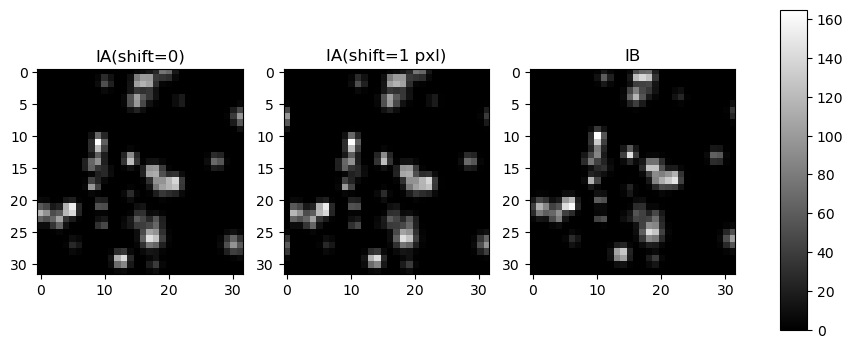

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(9, 4))

img = axs[0].imshow(a_win, cmap=plt.cm.gray)
axs[0].set_title("IA(shift=0)")

img = axs[1].imshow(np.roll(a_win, (0, 1), axis=(0, 1)), cmap=plt.cm.gray)
axs[1].set_title("IA(shift=1 pxl)")

img = axs[2].imshow(b_win, cmap=plt.cm.gray)
axs[2].set_title("IB")

cbar = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(img, cax=cbar)
plt.show()

If we now subtract from IB the shifted IA, we shall see how good the shift predicts the real displacement between the two.

**Assignment:** Modify the code below to minimize the difference between the shifted IA and IB. Share your comments.

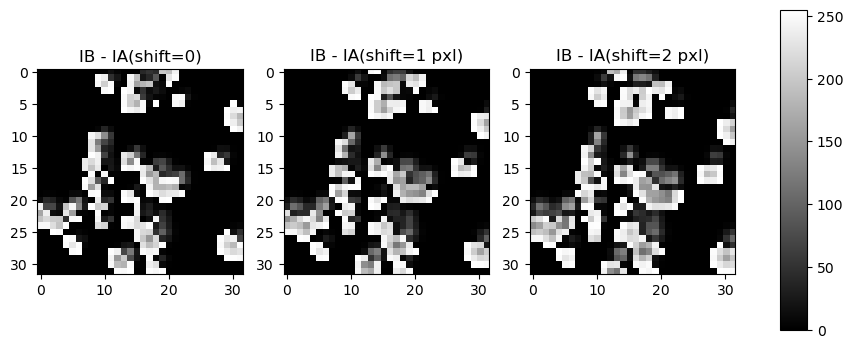

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(9, 4))

img = axs[0].imshow(b_win - a_win, cmap=plt.cm.gray)
axs[0].set_title("IB - IA(shift=0)")

img = axs[1].imshow(b_win - np.roll(a_win, (1, 0), axis=(0, 1)), cmap=plt.cm.gray)
axs[1].set_title("IB - IA(shift=1 pxl)")

img = axs[2].imshow(b_win - np.roll(a_win, (2, 0), axis=(0, 1)), cmap=plt.cm.gray)
axs[2].set_title("IB - IA(shift=2 pxl)")

cbar = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(img, cax=cbar)
plt.show()

Let's try to find the best shift algorithmically: shift and calculate the sum of squared differences, the minimum of which should be the best shift.

In [27]:
def match_template(img, template, maxroll=8):
    # img: input image to compare
    # template: image to match against
    # maxroll: max nbr of pxl to shift in each dir. Default value is 8.
    best_dist = np.inf
    best_shift = (-1, -1)
    for y in range(-maxroll,maxroll):
        for x in range(-maxroll,maxroll):
            # calculate Euclidean distance
            dist = np.sqrt(np.sum((img - np.roll(template, (y, x), axis=(0, 1))) ** 2))
            if dist < best_dist:
                best_dist = dist
                best_shift = (y, x)
    return (best_dist, best_shift)

Let's check that it works by manually shifting the same image (IA):

In [28]:
match_template(np.roll(a_win, (2, 0), axis=(0, 1)), a_win)

(0.0, (2, 0))

Indeed, when we find the correct shift, we get zero distance. It's not so in real images:

In [29]:
match_template(b_win, a_win)

(123.80226169178009, (-1, 1))

Well, this is not the true displacement, but it gives a hint. 

We could draw this as a vector of velocity

$$
    u = \frac{\Delta x \text{ pixels}}{\Delta t} ,\qquad v = \frac{\Delta y \text{ pixels}}{\Delta t}
$$

where $\Delta t$ is the time interval (delay) between the two images (or two laser pulses).

The problem is that shifting each image and repeating the loop many times is impractical. 

However, one can get it by using a different matching principle, based on the property called cross-correlation (cross because we use two different images). This is an efficient computational algorithm to find out the right shift. You can see more details here: http://paulbourke.net/miscellaneous/correlate/.

In [30]:
from scipy.signal import correlate

cross_corr = correlate(b_win - b_win.mean(), a_win - a_win.mean(), method="fft")
# Note that it's approximately twice as large as the original windows, as we
# can shift a_win by a maximum of its size horizontally and vertically
# while still maintaining some overlap between the two windows.
print("Size of the correlation map: %d x %d" % cross_corr.shape)

Size of the correlation map: 63 x 63


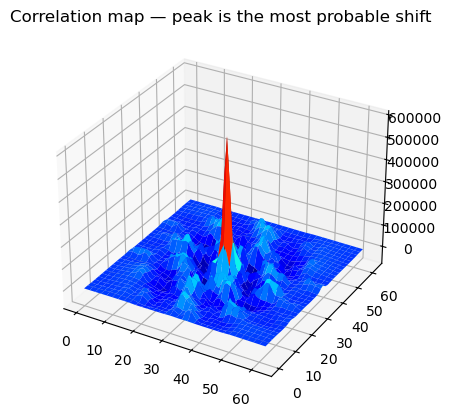

y=30, x=32


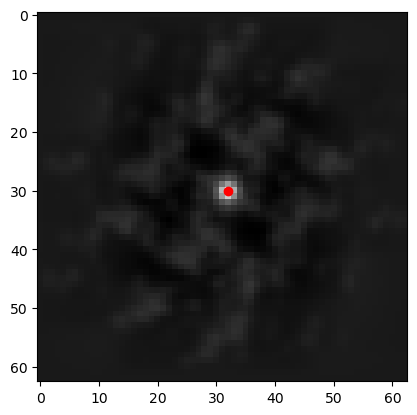

In [31]:
# let's see what the cross-correlation looks like
#from mpl_toolkits.mplot3d import Axes3D
Y, X = np.meshgrid(np.arange(cross_corr.shape[0]), np.arange(cross_corr.shape[1]))

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(Y, X, cross_corr, cmap='jet', linewidth=0.2)  # type: ignore
plt.title("Correlation map — peak is the most probable shift")
plt.show()

# let's see the same correlation map, from above
plt.imshow(cross_corr, cmap=plt.cm.gray)
y, x = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
print(f"{y=}, {x=}")
plt.plot(x, y, "ro")
plt.show()

The image of the correlation map shows the same result that we got manually looping. We need to substract the center of symmetry `(31, 31)` to get the estimated displacement.

In [32]:
dy, dx = y - 31, x - 31
print(f"{dy=}, {dx=}")

dy=-1, dx=1


We can get the first velocity field by repeating this analysis for all small windows. Let's take 32 x 32 pixels windows from each image and do the loop:

In [33]:
def vel_field(curr_frame, next_frame, win_size):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate(
                search_win - search_win.mean(), int_win - int_win.mean(), method="fft"
            )
            dys[iy, ix], dxs[iy, ix] = (
                np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
                - np.array([win_size, win_size])
                + 1
            )
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys

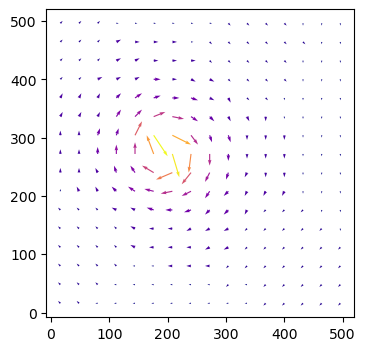

In [34]:
xs, ys, dxs, dys = vel_field(a, b, 32)
norm_drs = np.sqrt(dxs ** 2 + dys ** 2)

fig, ax = plt.subplots(figsize=(9, 4))
# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver(
    xs,
    ys[::-1],
    dxs,
    -dys,
    norm_drs,
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
ax.set_aspect("equal")
plt.show()

If you've followed along this far, great! Now you understand the basics.

We can also try out a variant of this that uses a search window larger than the interrogation window instead of relying on zero-padding. By avoiding using zero-padding around the search window, movement detection should theoretically be a bit better, assuming that the window sizes are chosen well.

In [35]:
def vel_field_asymmetric_wins(
    curr_frame, next_frame, half_int_win_size, half_search_win_size
):
    ys = np.arange(half_int_win_size[0], curr_frame.shape[0], 2 * half_int_win_size[0])
    xs = np.arange(half_int_win_size[1], curr_frame.shape[1], 2 * half_int_win_size[1])
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[
                y - half_int_win_size[0] : y + half_int_win_size[0],
                x - half_int_win_size[1] : x + half_int_win_size[1],
            ]
            search_win_y_min = y - half_search_win_size[0]
            search_win_y_max = y + half_search_win_size[0]
            search_win_x_min = x - half_search_win_size[1]
            search_win_x_max = x + half_search_win_size[1]
            truncated_search_win = next_frame[
                max(0, search_win_y_min) : min(b.shape[0], search_win_y_max),
                max(0, search_win_x_min) : min(b.shape[1], search_win_x_max),
            ]
            cross_corr = correlate(
                truncated_search_win - np.mean(truncated_search_win),
                int_win - np.mean(int_win),
                mode="valid",
                method="fft",
            )
            dy, dx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
            # if the top of the search window got truncated, shift the origin
            # up to the top edge of the (non-truncated) search window
            if search_win_y_min < 0:
                dy += -search_win_y_min
            # if the left of the search window got truncated, shift the origin
            # over to the left edge of the (non-truncated) search window
            if search_win_x_min < 0:
                dx += -search_win_x_min
            # shift origin to the center of the search window
            dy -= half_search_win_size[0] - half_int_win_size[0]
            dx -= half_search_win_size[1] - half_int_win_size[1]
            dys[iy, ix] = dy
            dxs[iy, ix] = dx
    return xs, ys, dxs, dys

In [36]:
int_win_size = np.array([32, 32])
print(f"{int_win_size=}")
assert np.all(np.array(a.shape) % int_win_size == 0)
assert np.all(int_win_size % 2 == 0)
half_int_win_size = int_win_size // 2

search_win_size = int_win_size * 2
print(f"{search_win_size=}")
assert np.all(search_win_size % 2 == 0)
half_search_win_size = search_win_size // 2
assert np.all(search_win_size > int_win_size)
print(
    "max velocity that can be detected with these window sizes: "
    + f"{half_search_win_size - half_int_win_size}"
)

int_win_size=array([32, 32])
search_win_size=array([64, 64])
max velocity that can be detected with these window sizes: [16 16]


Making the search window larger compared to the interrogation window would allow for larger velocities to be detected.

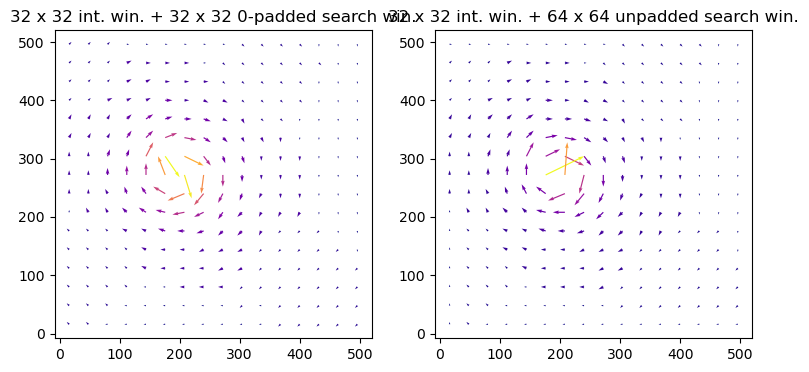

In [37]:
xs_asym, ys_asym, dxs_asym, dys_asym = vel_field_asymmetric_wins(
    a, b, half_int_win_size, half_search_win_size
)
norm_drs_asym = np.sqrt(dxs_asym ** 2 + dys_asym ** 2)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].quiver(
    xs,
    ys[::-1],
    dxs,
    -dys,
    norm_drs,
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
axs[1].quiver(
    xs_asym,
    ys_asym[::-1],
    dxs_asym,
    -dys_asym,
    norm_drs_asym,
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
axs[0].set_title(
    f"{win_size} x {win_size} int. win. + "
    f"{win_size} x {win_size} 0-padded search win."
)
axs[1].set_title(
    f"{int_win_size[0]} x {int_win_size[1]} int. win. + "
    f"{search_win_size[0]} x {search_win_size[0]} unpadded search win."
)
ax.set_aspect("equal")
plt.show()